### text-cnn + google's Word2Vec pre-trained model
paper:
- [Convolutional Neural Networks for Sentence Classification | Kim Yoon](https://arxiv.org/abs/1408.5882)

code reference (pre-process):
- https://www.kaggle.com/eliotbarr/text-classification-using-neural-networks
- https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/NLP_word_vectors_classification_rendered.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.text import Tokenizer
%matplotlib inline

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test_no_answer.csv')
df_train

,row_id,TEXT,LABEL
0,0,good to know if you can t find these elsewhere .,1
1,1,love it ! the grill plates come out and pop i...,1
2,2,i m convinced this was a poorly executed refur...,0
3,3,i would never have complained about that if it...,0
4,4,"the photo shows the same whole , large candie...",0
...,...,...,...
10995,10995,i didn t quite get it the first time .,1
10996,10996,i ve tried installing with and without the oem...,0
10997,10997,i was parked at a truck stop in the cincinnati...,0
10998,10998,i recently bought this case after seeing some ...,1


### Preprocessing text for the (supervised) Text-CNN model
The following cells uses Keras to preprocess text:

- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the 20000 most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)
- we convert the output classes as 1-hot encodings

In [3]:
# Prepossessing parameters
MAX_SEQUENCE_LENGTH = 50
MAX_NB_WORDS = 10000 # numbers of word in corpus

In [4]:
# get the raw text data
texts_train = df_train['TEXT'].astype(str)
texts_test = df_test['TEXT'].astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9872 unique tokens.


In [5]:
pprint(sequences[0])
pprint(df_train['TEXT'].loc[0])

[46, 6, 170, 37, 17, 33, 19, 195, 35, 856]
'good to know if you can t find these elsewhere .'


In [6]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 9872)

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):


In [7]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [8]:
# try to invert sequences[0] origin sentence
" ".join([index_to_word[i] for i in sequences[0]])

'good to know if you can t find these elsewhere'

#### Let's have a closer look at the tokenized sequences:

average length: 13.5
max length: 25


(array([  10.,  767.,  977., 1017., 1018., 1009.,  987.,  917.,  884.,
           0.,  837.,  762.,  728.,  708.,  277.,   78.,   18.,    4.,
           0.,    2.]),
 array([ 7. ,  7.9,  8.8,  9.7, 10.6, 11.5, 12.4, 13.3, 14.2, 15.1, 16. ,
        16.9, 17.8, 18.7, 19.6, 20.5, 21.4, 22.3, 23.2, 24.1, 25. ]),
 <a list of 20 Patch objects>)

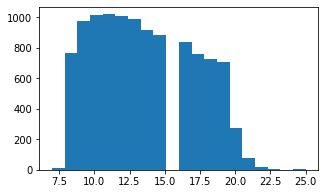

In [9]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))
plt.figure(figsize=(5,3))
plt.hist(seq_lens, bins=20)

### Prepare train/test sequences

In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (11000, 50)
Shape of data test tensor: (2000, 50)


In [11]:
y_train = to_categorical(np.asarray(df_train['LABEL'])) # has label as answer
y_test = df_test['LABEL'] # no label
print('Shape of label tensor:', y_train.shape)
print('Shape of label test tensor:', y_test.shape)

Shape of label tensor: (11000, 2)
Shape of label test tensor: (2000,)


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_val:', x_val.shape)
print('Shape of y_val:', y_val.shape)

Shape of x_train: (8800, 50)
Shape of y_train: (8800, 2)
Shape of x_val: (2200, 50)
Shape of y_val: (2200, 2)


### Model 1 : A simple Text-CNN model in Keras
- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 2 classes (+ softmax)

In [13]:
# Model Hyperparameters
EMBEDDING_DIM = 300
N_CLASSES = 2
filter_sizes = (3, 4, 5)
num_filters = 100          # paper is 100
dropout_prob = (0.5, 0.5)
hidden_dims = 100          # paper is 100

# Training parameters
batch_size = 64 # paper is 50
num_epochs = 10 # paper is 25

#### Initialize embedding matrix as embedding layer's weight

In [14]:
import gensim.downloader
word_vectors = gensim.downloader.load('word2vec-google-news-300')

word_index = tokenizer.word_index
vocabulary_size = min(len(word_index)+1, MAX_NB_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

# from keras.layers import Embedding
# embedding_layer = Embedding(vocabulary_size,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             trainable=True)

#### Model's framework

In [15]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate

def textcnn():
    # input: a sequence of MAX_SEQUENCE_LENGTH integers
    inputs = Input(name='inputs', shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    # embedding layer
    layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                      trainable=True, name="embedding",)(inputs)
    layer = Dropout(dropout_prob[0])(layer)
    # Convolutional block
    conv_blocks = []
    for sz in filter_sizes:
        conv = Convolution1D(filters     = num_filters,
                             kernel_size = sz,
                             padding     = "valid",
                             activation  = "relu",
                             strides     = 1)(layer)
        conv = MaxPooling1D(pool_size = 2)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    # Dropout & fully-connected
    z = Dropout(dropout_prob[1])(z)
    z = Dense(hidden_dims, activation="relu")(z)
    z = Dense(N_CLASSES, activation="softmax")(z)
    model = Model(inputs=inputs, outputs=z)
    
    return model

In [16]:
model = textcnn()
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      2961900     inputs[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 300)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 48, 100)      90100       dropout_1[0][0]                  
____________________________________________________________________________________________

In [17]:
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), 
          epochs=num_epochs, batch_size=batch_size)

C:\Users\Weber\.conda\envs\testAI\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8800 samples, validate on 2200 samples
Epoch 1/10
8800/8800 [==============================] - 19s 2ms/step - loss: 0.6841 - acc: 0.5652 - val_loss: 0.6318 - val_acc: 0.6459
Epoch 2/10
8800/8800 [==============================] - 18s 2ms/step - loss: 0.5753 - acc: 0.6956 - val_loss: 0.5255 - val_acc: 0.7445
Epoch 3/10
8800/8800 [==============================] - 18s 2ms/step - loss: 0.4630 - acc: 0.7831 - val_loss: 0.5168 - val_acc: 0.7514
Epoch 4/10
8800/8800 [==============================] - 18s 2ms/step - loss: 0.3803 - acc: 0.8284 - val_loss: 0.4882 - val_acc: 0.7664
Epoch 5/10
8800/8800 [==============================] - 19s 2ms/step - loss: 0.3186 - acc: 0.8615 - val_loss: 0.5220 - val_acc: 0.7450
Epoch 6/10
8800/8800 [==============================] - 19s 2ms/step - loss: 0.2612 - acc: 0.8898 - val_loss: 0.5337 - val_acc: 0.7641
Epoch 7/10
8800/8800 [==============================] - 19s 2ms/step - loss: 0.2072 - acc: 0.9173 - val_loss: 0.5827 - val_acc: 0.7559
Epoch 8

- 10 epoch: acc: 0.9535 - val_loss: 0.7759 - val_acc: 0.7491 <font color='red'>(paper param)</font>
明顯有over-fitting

ploting reference :https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


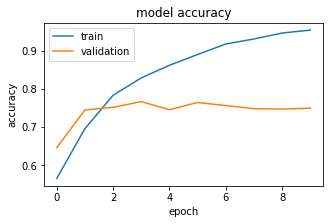

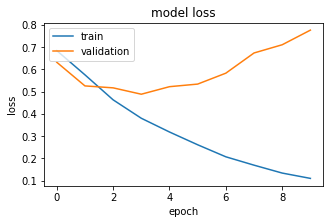

In [18]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(5,3))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### make submission
must convert probability predictions into categories (class label) first  
code reference: [Get class labels from Keras functional model](https://stackoverflow.com/questions/38971293/get-class-labels-from-keras-functional-model)

In [19]:
output_test = model.predict(x_test)
print(output_test[:5])
print(output_test.shape)

[[0.84328383 0.1567162 ]
 [0.22264452 0.7773555 ]
 [0.95737886 0.04262114]
 [0.9930668  0.0069332 ]
 [0.9015359  0.098464  ]]
(2000, 2)


In [20]:
y_classes = output_test[0].argmax(axis=-1)
y_classes

0

In [21]:
submission = {
    'row_id': list(range(0,len(output_test))),
    'LABEL': [x.argmax(axis=-1) for x in output_test]
}
submission = pd.DataFrame.from_dict(submission)
submission.head(3)

,row_id,LABEL
0,0,0
1,1,1
2,2,0


In [22]:
submission['LABEL'].value_counts()

0    1185
1     815
Name: LABEL, dtype: int64

In [23]:
# submission.to_csv('submission/sub_texcnn word2vec.csv', index=False)